In [1]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [2]:
# from numba import cuda
from keras import backend as K

from pymongo import MongoClient
from bson.objectid import ObjectId

import time,datetime
import os

import pandas as pd
import pandas_datareader.data as web
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import style

from keras.models import Model, Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
import keras
from keras.callbacks import TensorBoard

from sklearn import preprocessing

from copy import deepcopy
from IPython.display import clear_output

In [3]:
style.use('ggplot')

In [4]:
conn = MongoClient('120.126.136.17')
db = conn.Tracker
collection = [db.james]# db.db2, db.dn2, db.james, db.leo
clean_data = []
for col in collection:
    cursor = col.find({})
    df = pd.DataFrame(list(cursor))
df['step_value'].replace('', 0, inplace=True)
df.replace('', np.nan, inplace=True)
df.fillna(method='ffill', inplace=True)

df['hr_value'] = df['hr_value'].astype(float)
df['o2_value'] = df['o2_value'].astype(float)
df['latitude'] = df['latitude'].astype(float)
df['longitude'] = df['longitude'].astype(float)
df['step_value'] = df['step_value'].astype(float)

# map out the weekday
df['weekday'] = df['timestamp'].apply(lambda x: int(datetime.datetime.fromtimestamp(x).strftime('%w')))
df['week'] = df['timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x).isocalendar()[1]
          - (datetime.datetime.fromtimestamp(x).isoweekday() < 7)) # do this so that week may start on monday

In [5]:
df = df.drop('_id',axis=1)

In [6]:
df['tdiff'] = df['timestamp'].diff()

In [7]:
df = df.set_index('timestamp')

In [8]:
dferror = df.loc[((df.index < datetime.datetime(2019,5,14).timestamp()) & (df['step_value'] !=0))]

In [9]:
dferror['insertnum'] = (dferror['tdiff'] / 10).round(0) 

/home/james/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [10]:
for i in dferror.index:
    start_step = df.loc[i - df.loc[i, 'tdiff'], 'step_value']
    end_step = df.loc[i,'step_value']
    for j in range(1, int(dferror.loc[i,'insertnum']) + 2):
        add = df.loc[i]
        add['step_value'] = int(start_step + (end_step - start_step)/(int(dferror.loc[i,'insertnum']) + 1)*((int(dferror.loc[i,'insertnum']) + 2 - j)))
        df.loc[i - 10*j] = add

/home/james/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [12]:
df['tdiff'] = df.diff()

In [13]:
df = df.sort_index()
df = df.reset_index()

In [61]:
dfstephour = pd.DataFrame({})
dfstephour = df[['week', 'weekday']].set_index(['week', 'weekday'])
dfstephour = dfstephour[~dfstephour.index.duplicated(keep='first')]
earlestweek = int(df['week'].values[0])
latestweek = int(df['week'].values[-1])
addindex = pd.DataFrame({})
for i in range(earlestweek, latestweek):
    for j in range(7):
        if not (i,j) in dfstephour.index:
            add = pd.DataFrame({'week':[i],'weekday':[j]})
            addindex = addindex.append(add)
dfstephour.reset_index(inplace=True)
dfstephour = dfstephour.append(addindex)
dfstephour = dfstephour.set_index(['week', 'weekday'])
dfstephour = dfstephour.sort_index()
for i in range(24):
    dfstephour[i] = 0

# here I map between integer and the sting it's mean
timeslidemap = {0:'msteps', 1:'asteps', 2:'esteps'}
basestamp = df['timestamp'][0]
endstamp = df['timestamp'][-1:].values[0]
# for num, row in df[:30000].iterrows():
while True:
    try:
        hour = datetime.datetime.fromtimestamp(basestamp).hour
        dfbetween = df.loc[df['timestamp'].between(
            datetime.datetime.fromtimestamp(basestamp).replace(hour=hour,minute=0,second=0).timestamp(),
            datetime.datetime.fromtimestamp(basestamp).replace(hour=hour,minute=59,second=59).timestamp()
                    , inclusive=True)]
        steps = dfbetween['step_value'].sum()
    #     print(int(datetime.datetime.fromtimestamp(basestamp).strftime('%m')),
    #             int(datetime.datetime.fromtimestamp(basestamp).strftime('%d')),
    #                 timeslidemap[estimedevide])

        dfstephour.loc[[(datetime.datetime.fromtimestamp(basestamp).isocalendar()[1] - 
                                    (datetime.datetime.fromtimestamp(basestamp).isoweekday() < 7),
                            int(datetime.datetime.fromtimestamp(basestamp).strftime('%w')))], 
                                           [hour]] += steps

        basestamp = (datetime.datetime.fromtimestamp(basestamp) + datetime.timedelta(hours=1)).timestamp()
        if basestamp > endstamp:
            break
    except Exception as e:
#         print(str(e))
        basestamp = (datetime.datetime.fromtimestamp(basestamp) + datetime.timedelta(hours=1)).timestamp()
#     else:
#         print(datetime.datetime.fromtimestamp(basestamp) ,datetime.datetime.fromtimestamp(endstamp))

dfstephour = dfstephour.drop([(12,0),(12,1),(12,2),(12,3),(12,4),(12,5),(12,6)])

steps = dfstephour.values
train_X = []
for weekday,i in enumerate(steps):
    for hour,j in enumerate(i):
        add = np.array([j])#[weekday, hour, j]
        train_X.append(add)
# the ending of training data is the  hour of now 
# train_X = train_X[:-(24-datetime.datetime.now().time().hour + 1)]
train_X = np.array(train_X)

In [16]:
# coefficient of determination (R^2) for regression
def r_square(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def r_square_loss(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return 1 - ( 1 - SS_res/(SS_tot + K.epsilon()))

def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

tbCallBack = TensorBoard(log_dir='./logs',  # log 目录
             histogram_freq=0,  # 按照何等频率（epoch）来计算直方图，0为不计算
#                  batch_size=32,     # 用多大量的数据计算直方图
             write_graph=True,  # 是否存储网络结构图
             write_grads=True, # 是否可视化梯度直方图
             write_images=True,# 是否可视化参数
             embeddings_freq=0, 
             embeddings_layer_names=None, 
             embeddings_metadata=None)

In [17]:
# split a multivariate sequence into samples
def split_sequences_hour(sequences, n_steps):
    X, y = list(), list()
#     for i in range(len(sequences)):
#     # find the end of this pattern
#         end_ix = i + n_steps
# #         print(end_ix)
#         #check if we are beyond the dataset
#         if end_ix > len(sequences)-1:
#             break
#         # gather input and output parts of the pattern
#         seq_x = sequences[i:end_ix]#.reshape(len(sequences[i:end_ix]),1) 
# #         print(seq_x)
# #         break
# #         seq_x = np.append(seq_x, sequences[1][i:end_ix].reshape(len(sequences[1][i:end_ix]),1), axis=1)
# #         seq_x = np.append(seq_x, sequences[2][i:end_ix].reshape(len(sequences[2][i:end_ix]),1), axis=1)
#         seq_y = sequences[end_ix][-1]
#         X.append(seq_x)
#         y.append(seq_y)
#     return np.array(X), np.array(y)

In [99]:
# split a multivariate sequence into samples
def split_sequences_hour(sequences, n_steps):
    X, y = list(), list()
    for i in range(7):
        for k in range(7,9):
            for j in range(int(sequences.shape[0] / 7 / 24)):
                end_ix = j + n_steps
                if (end_ix + 1)*7*24 > sequences.shape[0]:
                    break
#                 print(end_ix)
                seq_x = sequences[(i+k)+168*j:(end_ix*7*24+k):168]
#                 print(seq_x)
                seq_y = sequences[end_ix*7*24+k]
#                 print(seq_y)
                X.append(seq_x)
                y.append(seq_y)
    return np.array(X), np.array(y)

In [100]:
steps = dfstephour.values
train_X = []
for weekday,i in enumerate(steps):
    for hour,j in enumerate(i):
        add = np.array([j])#[weekday, hour, j]
        train_X.append(add)
train_X = np.array(train_X)
# normalized_X = preprocessing.scale(train_X)
# normalized_Y = preprocessing.normalize()
# normalstack_X = np.hstack(normalized_X)
# normalized_Y = preprocessing.normalize([Comfort])
# normalized_Z = preprocessing.normalize([Precp])
# dataset = np.array([normalized_X[0],normalized_Y[0],normalized_Z[0]])
# n_steps = 3
# X, y = split_sequences_hour(train_X, n_steps)
# for i in range(70,100):
#     print(train_X[i])
#     print(X[i], y[i])

In [188]:
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred -y_true)))

In [204]:
n_steps = 3
X, y = split_sequences_hour(train_X, n_steps)

n_features = 1
model = Sequential()
model.add(keras.layers.LSTM(60, activation='relu', return_sequences=True,input_shape=(n_steps, n_features),dropout=0.1))
model.add(keras.layers.LSTM(30, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adamax', loss='mae', metrics=['mae'])# 
history = model.fit(X, y, epochs=600, verbose=0, batch_size=128, validation_split=0.2, callbacks=[tbCallBack])

del model

<IPython.core.display.Javascript object>


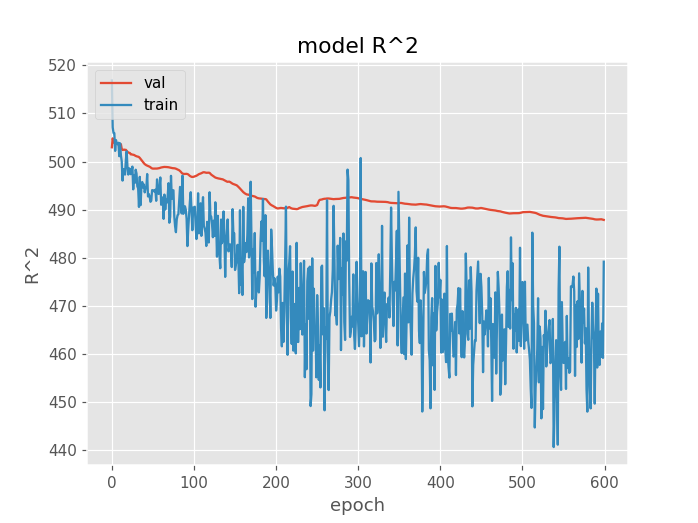

In [205]:
%matplotlib notebook
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('model R^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['val', 'train'], loc='upper left')
plt.show()

In [126]:
from sklearn.model_selection import StratifiedKFold

In [124]:
seed = 7
np.random.seed(seed)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

for train, test in kfold.split(X, y):
    n_features = 1
    model = Sequential()
    model.add(keras.layers.LSTM(60, activation='relu', return_sequences=True,input_shape=(n_steps, n_features),dropout=0.1))
    model.add(keras.layers.LSTM(30, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mae',metrics=[r2_keras])# 
    history = model.fit(X, y, epochs=1000, verbose=0, batch_size=128, validation_split=0.2, callbacks=[tbCallBack])


70/70 [==============================] - 0s 176us/step


[403.7511134556362, -0.013306478091648647]

<IPython.core.display.Javascript object>


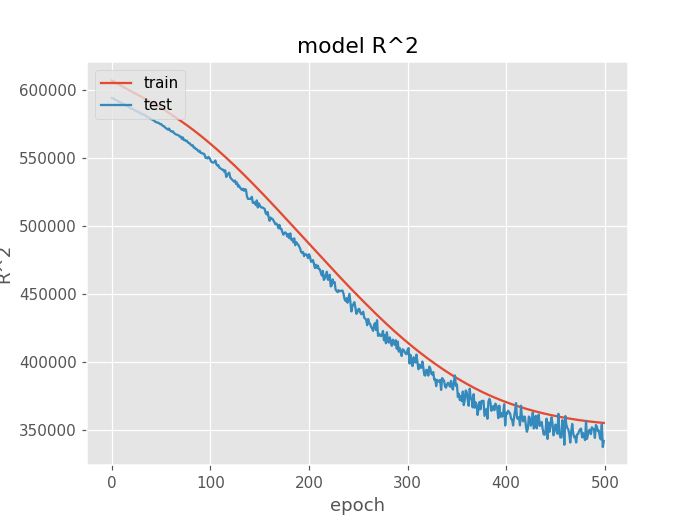

In [120]:
%matplotlib notebook
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('model R^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

<IPython.core.display.Javascript object>


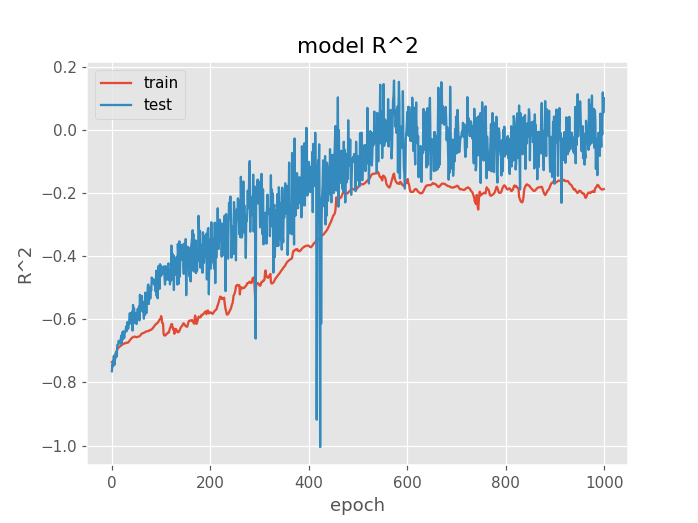

In [118]:
%matplotlib notebook
plt.plot(history.history['val_r2_keras'])
plt.plot(history.history['r2_keras'])
plt.title('model R^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [113]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import SimpleRNN,RNN

In [119]:
n_steps = 3
X, y = split_sequences_hour(train_X, n_steps)

n_features = 1
model = Sequential()
model.add(SimpleRNN(units=60,input_shape=(n_steps, n_features)))
# model.add(SimpleRNN(units=30))
model.add(Dense(units=30,activation='selu'))
model.add(Dropout(0.1))
model.add(Dense(units=1,activation='selu'))
model.compile(optimizer='adam', loss='mse',metrics=[r_square])# 

history = model.fit(X, y, epochs=500, verbose=0, batch_size=128, validation_split=0.2, callbacks=[tbCallBack])
del model

<IPython.core.display.Javascript object>


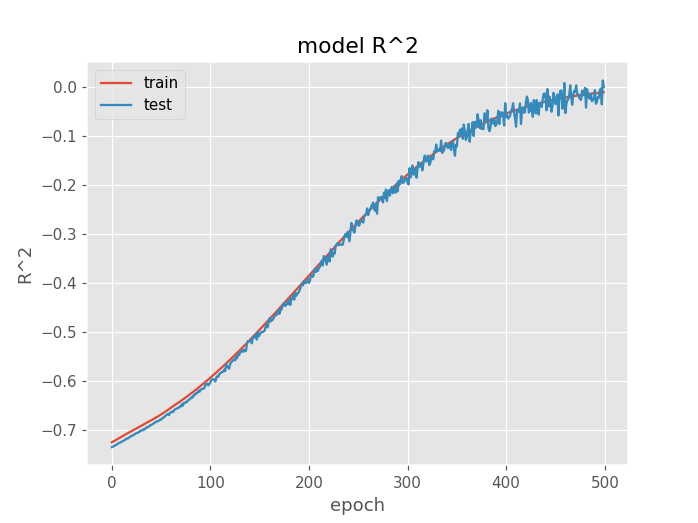

In [122]:
%matplotlib notebook
plt.plot(history.history['val_r_square'])
plt.plot(history.history['r_square'])
plt.title('model R^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()